## Imports

In [1]:
from pySimFinLib import pySimFin
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

psf = pySimFin()

## Data Loading

In [2]:
companies = ['microsoft']
start_date = '2020-01-01'
end_date = '2024-01-01'

df = psf.get_share_prices(companies,start_date,end_date)
df = df.droplevel(0)
df = df.sort_index()  

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/simfin/load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Done!


In [3]:
type(df)

pandas.core.frame.DataFrame

## Modelling

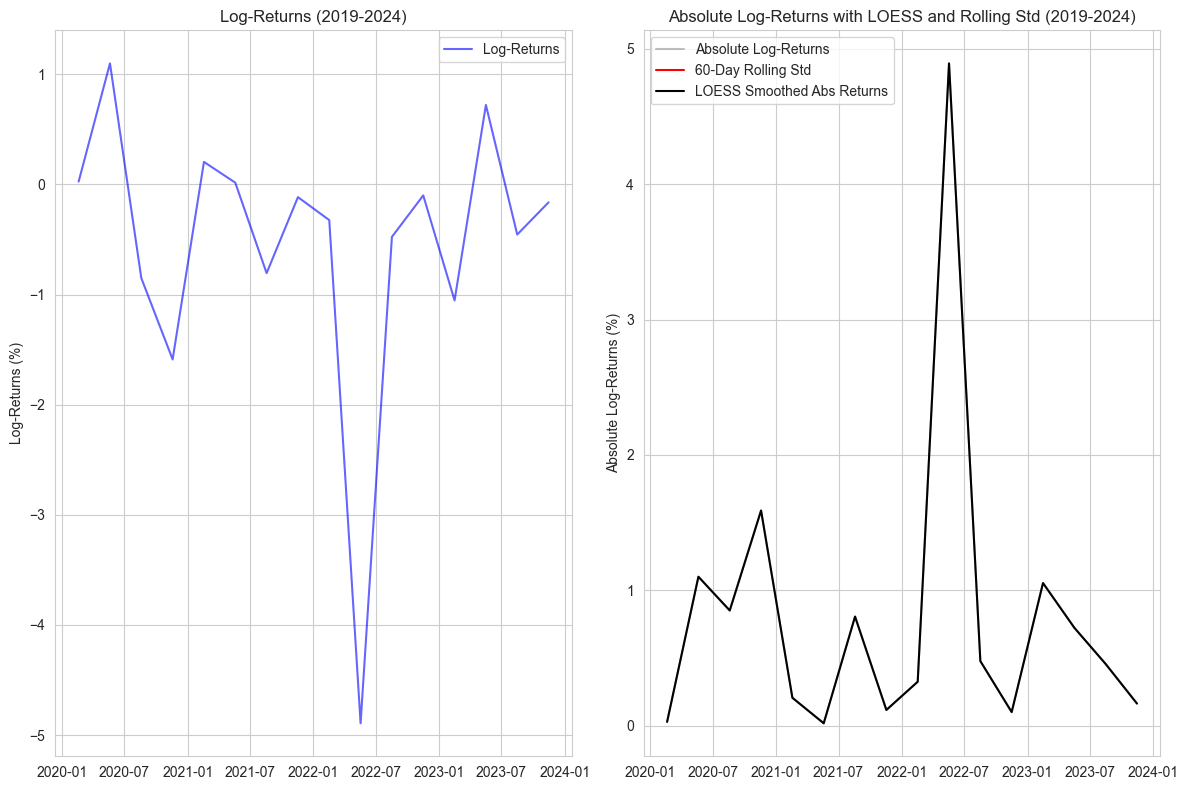

In [4]:
# Compute percentage log-returns
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
df.dropna(inplace=True)

# Compute absolute log-returns
df['Abs_Log_Return'] = np.abs(df['Log_Return'])

# Compute rolling 60-day standard deviation
df['Rolling_Std'] = df['Log_Return'].rolling(window=60).std()

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(df['Abs_Log_Return'], df.index, frac=0.03)  # frac=0.03 controls smoothness

# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

# Plot log-returns
top_ax = axes[0]
top_ax.plot(df.index, df['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
top_ax.set_ylabel("Log-Returns (%)")
top_ax.set_title("Log-Returns (2019-2024)")
top_ax.legend()

# Plot absolute log-returns with LOESS and rolling std
bottom_ax = axes[1]
bottom_ax.plot(df.index, df['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
bottom_ax.plot(df.index, df['Rolling_Std'], color='red', label='60-Day Rolling Std')
bottom_ax.plot(df.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
bottom_ax.set_ylabel("Absolute Log-Returns (%)")
bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2019-2024)")
bottom_ax.legend()

plt.tight_layout()
plt.show()

In [12]:
df.sample(10)

,SimFinId,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding,Log_Return,Abs_Log_Return,Rolling_Std
Date,,,,,,,,,,,,
2023-11-15,59265,371.28,373.13,367.11,369.67,366.22,26860095,0.75,7.446000e+09,-0.162175,0.162175,NaN
2023-05-17,59265,312.29,314.43,310.74,314.00,309.78,24315012,0.68,7.451000e+09,0.722348,0.722348,NaN
2021-11-17,59265,338.94,342.19,338.00,339.12,329.87,19053380,0.62,7.531575e+09,-0.114937,0.114937,NaN
2022-08-17,59265,289.74,293.35,289.47,291.32,285.26,18253358,0.62,7.474000e+09,-0.476004,0.476004,NaN
2021-08-18,59265,292.04,294.82,290.27,290.73,282.28,21812985,0.56,7.531575e+09,-0.805061,0.805061,NaN
2023-08-16,59265,320.80,324.42,319.80,320.40,316.77,20698864,0.68,7.434000e+09,-0.454645,0.454645,NaN
2020-08-19,59265,211.49,212.10,209.25,209.70,201.75,27627561,0.51,7.567653e+09,-0.849978,0.849978,NaN
2020-02-19,59265,188.06,188.18,186.47,187.28,179.25,29997471,0.51,7.606047e+09,0.026702,0.026702,NaN
2021-02-17,59265,241.32,244.31,240.94,244.20,236.11,21451617,0.56,7.542216e+09,0.204960,0.204960,NaN
